In [1]:
! pip install --upgrade langchain-text-splitters langchain-community langgraph bs4

  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_community-0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached pydantic-2.12.3-py3-none-any.whl.metadata (87 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached zstandard-0.25.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata

# Mvp text2text минимальная первая версия

1) Заранее загружается ссылка на веб-страницу. Оттуда парсится контент и сохраняется в виде эмбеддингов в вектроном хранилище
2) Приходит текст вопроса. Текст переводится в вектор. Он захватывает именно семантическое значение вопроса
3) Этот вектор и сохраненные в хранилище векторы сравниваются. Находятся наиболее похожие чанки
4) Топ N чанков вставляется в промпт и отдается нейросети

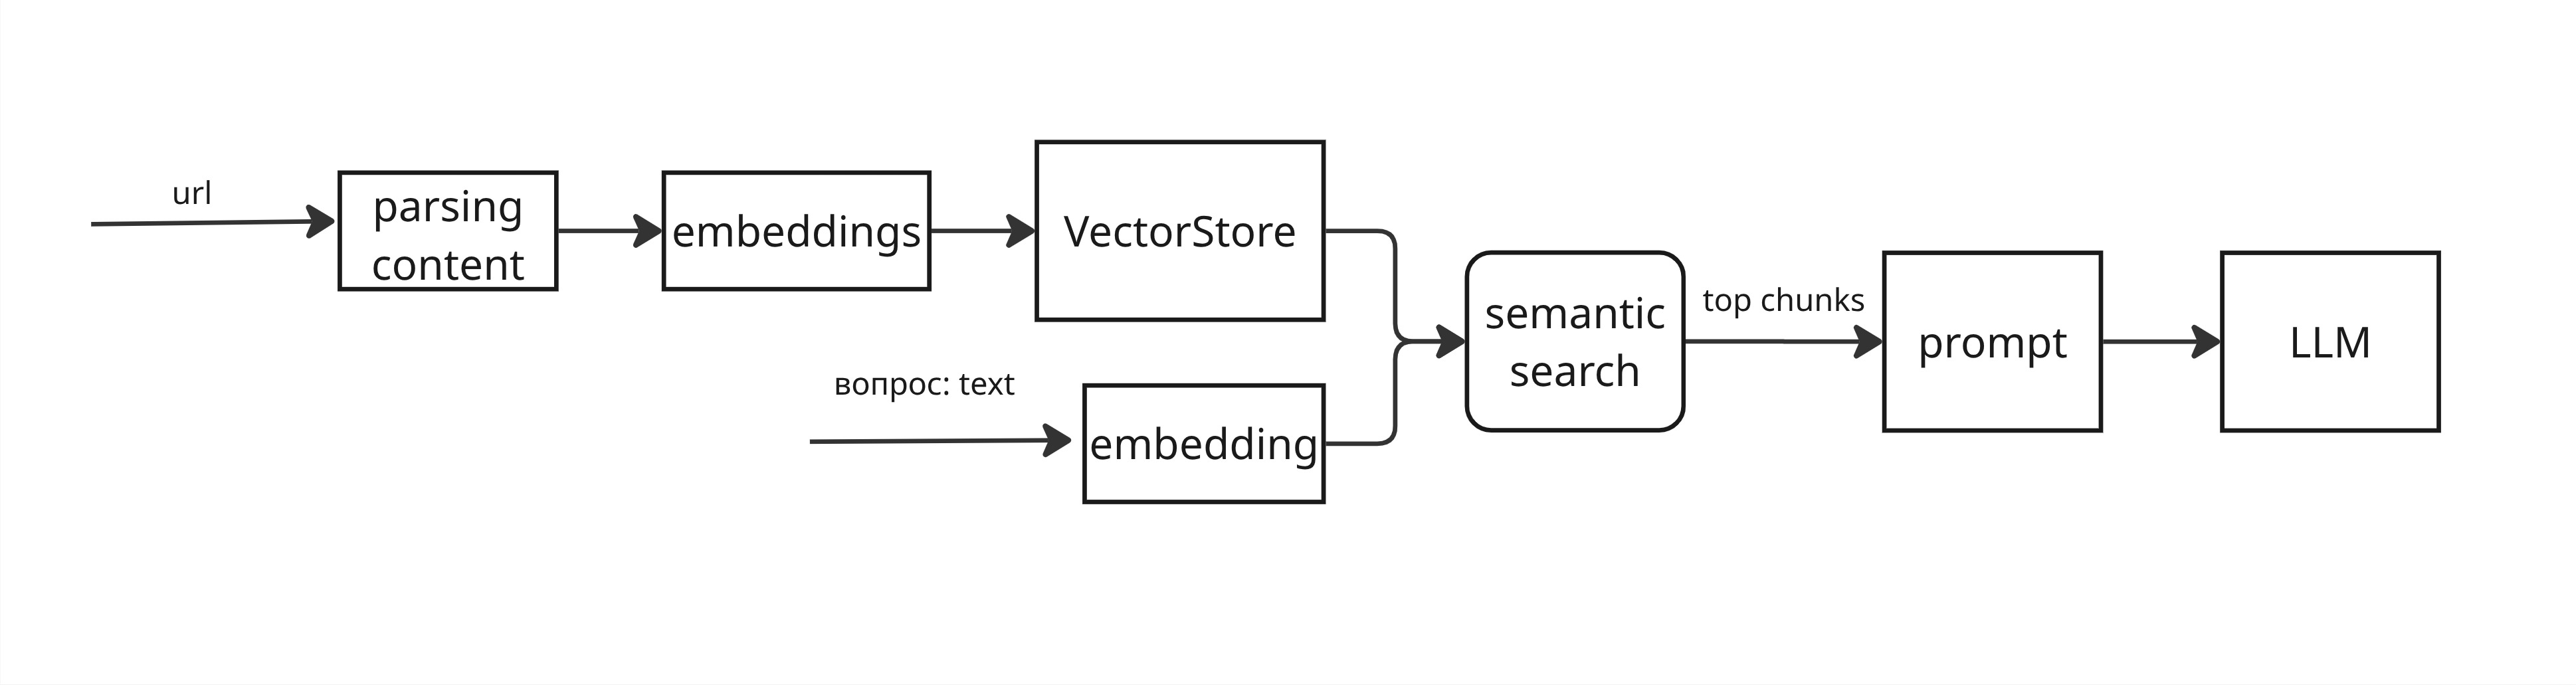

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv('LANGSMITH_API_KEY')
os.environ["GOOGLE_API_KEY"] = os.getenv('GEMINI_API_KEY')

In [3]:
! pip install -qU "langchain[google-genai]"
! pip install -qU langchain-google-genai
! pip install -qU langchain-core
! pip install langchain-hub

ERROR: Could not find a version that satisfies the requirement langchain-hub (from versions: none)
ERROR: No matching distribution found for langchain-hub


In [4]:
from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
vector_store = InMemoryVectorStore(embeddings)

In [6]:
import bs4
# from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

url = 'https://vc.ru/services/1067128-2500-v-mesyac-na-servise-s-1-funkciei-kotoraya-uzhe-byla-u-krupnyh-kompanii/'

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=(url,),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=('content')
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
# prompt = hub.pull("rlm/rag-prompt")


from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.

Context: {context}"""),
    ("human", "Question: {question}")
])


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

GoogleGenerativeAIError: Error embedding content: 400 User location is not supported for the API use.

In [ ]:
response = graph.invoke({"question": "какой Хороший пример инди-запуска?"})
print(response["answer"])